
#Import Libraries

In [1]:
!pip install imbalanced-learn scikit-learn

import pandas as pd

from google.colab import drive
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

#Cek Dataset(Optional)


### If u have 2 or more dataset and want to compare the label and the data of both

In [2]:
# drive.mount('/content/drive')

# # Path file di Google Drive
# file_path_1 = '/content/drive/MyDrive/capstone/diabetes_prediction_dataset1.csv'
# file_path_2 = '/content/drive/MyDrive/capstone/preprocessed_diabetes_data.csv'

# # Membaca file CSV dari Google Drive
# df1 = pd.read_csv(file_path_1)
# df2 = pd.read_csv(file_path_2)


# # Memeriksa apakah kedua dataset memiliki dimensi yang sama
# if df1.shape == df2.shape:
#     print("Dataset memiliki jumlah baris dan kolom yang sama.")

#     # Membandingkan apakah kedua dataset sama persis
#     if df1.equals(df2):
#         print("Isi kedua dataset sama persis.")
#     else:
#         print("Isi kedua dataset berbeda.")
#         # Menampilkan perbedaan secara lebih mendetail
#         comparison = df1.compare(df2)
#         print("Perbedaan antara kedua dataset:")
#         print(comparison)
# else:
#     print("Dataset memiliki jumlah baris atau kolom yang berbeda.")

#Data Gathering

In [3]:
drive.mount('/content/drive')

# Path file di Google Drive
file_path = '/content/drive/MyDrive/capstone/diabetes_prediction_dataset.csv'

# Membaca file CSV dari Google Drive
df = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Preprocessing Data

In [4]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [6]:
df.isna().sum()

,0
gender,0
age,0
hypertension,0
heart_disease,0
smoking_history,0
bmi,0
HbA1c_level,0
blood_glucose_level,0
diabetes,0


In [7]:
print(df.isnull().sum())

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64


In [8]:
print("Jumlah duplikasi: ", df.duplicated().sum())

Jumlah duplikasi:  3854


In [9]:
df[df.duplicated()]

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
2756,Male,80.0,0,0,No Info,27.32,6.6,159,0
3272,Female,80.0,0,0,No Info,27.32,3.5,80,0
3418,Female,19.0,0,0,No Info,27.32,6.5,100,0
3939,Female,78.0,1,0,former,27.32,3.5,130,0
3960,Male,47.0,0,0,No Info,27.32,6.0,200,0
...,...,...,...,...,...,...,...,...,...
99980,Female,52.0,0,0,never,27.32,6.1,145,0
99985,Male,25.0,0,0,No Info,27.32,5.8,145,0
99989,Female,26.0,0,0,No Info,27.32,5.0,158,0
99990,Male,39.0,0,0,No Info,27.32,6.1,100,0


In [10]:
print(df['smoking_history'].unique())

['never' 'No Info' 'current' 'former' 'ever' 'not current']


In [11]:
# Menghitung jumlah individu berdasarkan kategori risiko
smoking_counts = df['smoking_history'].value_counts()

# Menampilkan hasil
print(smoking_counts)

smoking_history
No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: count, dtype: int64


In [12]:
def classify_diabetes(row):
    glucose = row['blood_glucose_level']
    hba1c = row['HbA1c_level']
    bmi = row['bmi']
    age = row['age']
    hypertension = row['hypertension']
    heart_disease = row['heart_disease']
    smoking = row['smoking_history']
    gender = row['gender']
    # Risiko berdasarkan smoking_history
    if glucose > 140 or hba1c >= 7.0 or (hypertension == 1 and heart_disease == 1):
        return 'Diabetes Tidak Terkendali'

    # Diabetes Terkendali
    if 126 <= glucose <= 140 or 6.5 <= hba1c < 7.0:
        if hypertension == 0 and heart_disease == 0:
            return 'Diabetes Terkendali'
        return 'Diabetes Tidak Terkendali'

    # Pra-diabetes
    if 100 <= glucose < 126 or 5.7 <= hba1c < 6.5 or bmi >= 25:
        # Gender-specific rules
        if gender == 'Female' and bmi >= 30:
            return 'Pra-diabetes'
        elif gender == 'Male' and bmi >= 27:
            return 'Pra-diabetes'
        # Additional risk factors
        if age > 45 or smoking in ['current', 'ever'] or hypertension == 1:
            return 'Pra-diabetes'

    # Normal
    return 'Normal'

# Menambahkan kolom diabetes_category dengan logika baru
df['diabetes_category'] = df.apply(classify_diabetes, axis=1)

print(df)

       gender   age  hypertension  heart_disease smoking_history    bmi  \
0      Female  80.0             0              1           never  25.19   
1      Female  54.0             0              0         No Info  27.32   
2        Male  28.0             0              0           never  27.32   
3      Female  36.0             0              0         current  23.45   
4        Male  76.0             1              1         current  20.14   
...       ...   ...           ...            ...             ...    ...   
99995  Female  80.0             0              0         No Info  27.32   
99996  Female   2.0             0              0         No Info  17.37   
99997    Male  66.0             0              0          former  27.83   
99998  Female  24.0             0              0           never  35.42   
99999  Female  57.0             0              0         current  22.43   

       HbA1c_level  blood_glucose_level  diabetes          diabetes_category  
0              6.6  

In [13]:
# Menghitung jumlah individu berdasarkan kategori risiko
diabetes_counts = df['diabetes_category'].value_counts()

# Menampilkan hasil
print(diabetes_counts)

diabetes_category
Diabetes Tidak Terkendali    52091
Diabetes Terkendali          24783
Pra-diabetes                 14086
Normal                        9040
Name: count, dtype: int64


In [14]:
label_encoder = LabelEncoder()
df['gender_encoded'] = label_encoder.fit_transform(df['gender'])

# Tentukan urutan yang diinginkan
smoking_order = ['No Info', 'never', 'former', 'current', 'not current', 'ever']

# Gunakan pd.Categorical untuk memberikan urutan pada kategori
df['smoking_history_encoded'] = pd.Categorical(df['smoking_history'], categories=smoking_order, ordered=True).codes

# Tentukan urutan yang diinginkan
diabetes_order = ['Normal', 'Pra-diabetes', 'Diabetes Terkendali', 'Diabetes Tidak Terkendali']

# Gunakan pd.Categorical untuk memberikan urutan pada kategori
df['diabetes_category_encoded'] = pd.Categorical(df['diabetes_category'], categories=diabetes_order, ordered=True).codes

print(df)

       gender   age  hypertension  heart_disease smoking_history    bmi  \
0      Female  80.0             0              1           never  25.19   
1      Female  54.0             0              0         No Info  27.32   
2        Male  28.0             0              0           never  27.32   
3      Female  36.0             0              0         current  23.45   
4        Male  76.0             1              1         current  20.14   
...       ...   ...           ...            ...             ...    ...   
99995  Female  80.0             0              0         No Info  27.32   
99996  Female   2.0             0              0         No Info  17.37   
99997    Male  66.0             0              0          former  27.83   
99998  Female  24.0             0              0           never  35.42   
99999  Female  57.0             0              0         current  22.43   

       HbA1c_level  blood_glucose_level  diabetes          diabetes_category  \
0              6.6 

In [15]:
print(df['diabetes_category_encoded'].unique())
print(df['smoking_history_encoded'].unique())

[3 2 1 0]
[1 0 3 2 5 4]


In [16]:
# Menghitung jumlah individu berdasarkan kategori risiko
smoking_counts = df['smoking_history_encoded'].value_counts()

# Menampilkan hasil
print(smoking_counts)

smoking_history_encoded
0    35816
1    35095
2     9352
3     9286
4     6447
5     4004
Name: count, dtype: int64


In [17]:
df.describe(include='all')

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,diabetes_category,gender_encoded,smoking_history_encoded,diabetes_category_encoded
count,100000,100000.000000,100000.00000,100000.000000,100000,100000.000000,100000.000000,100000.000000,100000.000000,100000,100000.000000,100000.00000,100000.000000
unique,3,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN
top,Female,NaN,NaN,NaN,No Info,NaN,NaN,NaN,NaN,Diabetes Tidak Terkendali,NaN,NaN,NaN
freq,58552,NaN,NaN,NaN,35816,NaN,NaN,NaN,NaN,52091,NaN,NaN,NaN
mean,NaN,41.885856,0.07485,0.039420,NaN,27.320767,5.527507,138.058060,0.085000,NaN,0.414660,1.27465,2.199250
std,NaN,22.516840,0.26315,0.194593,NaN,6.636783,1.070672,40.708136,0.278883,NaN,0.493031,1.40306,0.991806
min,NaN,0.080000,0.00000,0.000000,NaN,10.010000,3.500000,80.000000,0.000000,NaN,0.000000,0.00000,0.000000
25%,NaN,24.000000,0.00000,0.000000,NaN,23.630000,4.800000,100.000000,0.000000,NaN,0.000000,0.00000,2.000000
50%,NaN,43.000000,0.00000,0.000000,NaN,27.320000,5.800000,140.000000,0.000000,NaN,0.000000,1.00000,3.000000
75%,NaN,60.000000,0.00000,0.000000,NaN,29.580000,6.200000,159.000000,0.000000,NaN,1.000000,2.00000,3.000000


In [18]:
# Menghitung jumlah individu berdasarkan kategori risiko
diabetes_counts = df['diabetes_category_encoded'].value_counts()

# Menampilkan hasil
print(diabetes_counts)

diabetes_category_encoded
3    52091
2    24783
1    14086
0     9040
Name: count, dtype: int64


In [19]:
# Menampilkan data pasien per kategori diabetes berdasarkan 'diabetes_category_encoded'
# Misalnya kategori: 0 = Normal, 1 = Pra-diabetes, 2 = Diabetes Terkendali, 3 = Diabetes Tidak Terkendali

# Kategori 'Normal'
normal_data = df[df['diabetes_category_encoded'] == 0]
print("Data Pasien - Normal:")
print(normal_data)

# Kategori 'Pra-diabetes'
pra_diabetes_data = df[df['diabetes_category_encoded'] == 1]
print("\nData Pasien - Pra-diabetes:")
print(pra_diabetes_data)

# Kategori 'Diabetes Terkendali'
diabetes_terkendali_data = df[df['diabetes_category_encoded'] == 2]
print("\nData Pasien - Diabetes Terkendali:")
print(diabetes_terkendali_data)

# Kategori 'Diabetes Tidak Terkendali'
diabetes_tidak_terkendali_data = df[df['diabetes_category_encoded'] == 3]
print("\nData Pasien - Diabetes Tidak Terkendali:")
print(diabetes_tidak_terkendali_data)


Data Pasien - Normal:
       gender   age  hypertension  heart_disease smoking_history    bmi  \
9      Female  32.0             0              0           never  27.32   
18     Female  42.0             0              0         No Info  27.32   
21       Male   5.0             0              0         No Info  18.80   
22     Female  69.0             0              0           never  21.24   
33     Female  20.0             0              0           never  22.19   
...       ...   ...           ...            ...             ...    ...   
99958  Female  38.0             0              0     not current  23.58   
99969  Female  30.0             0              0           never  22.88   
99975  Female  41.0             0              0         No Info  27.32   
99981    Male  26.0             0              0         No Info  24.08   
99987  Female  23.0             0              0           never  17.87   

       HbA1c_level  blood_glucose_level  diabetes diabetes_category  \
9     

#Building Model

In [20]:
# Pisahkan fitur (X) dan target (y)
X = df.drop(columns=['gender','smoking_history','diabetes', 'diabetes_category', 'diabetes_category_encoded'])
y = df['diabetes_category_encoded']

print(X.head())

# Menentukan strategi sampling agar setiap kelas memiliki 9040 data
sampling_strategy = {
    3: 9040,  # Diabetes Tidak Terkendali
    2: 9040,  # Diabetes Terkendali
    1: 9040,  # Pra-diabetes
    0: 9040   # Normal
}

# Membuat instance RandomUnderSampler dengan sampling_strategy dictionary
under_sampler = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)

# Lakukan under-sampling pada dataset
X_resampled, y_resampled = under_sampler.fit_resample(X, y)

# Menampilkan distribusi kelas setelah under-sampling
print(f"Distribusi kelas setelah under-sampling: {Counter(y_resampled)}")

# Membagi data yang sudah di-resample menjadi data pelatihan dan data validasi
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Cek bentuk data untuk memastikan pembagian yang benar
print(f"Jumlah data pelatihan: {X_train.shape[0]}")
print(f"Jumlah data validasi: {X_val.shape[0]}")

    age  hypertension  heart_disease    bmi  HbA1c_level  blood_glucose_level  \
0  80.0             0              1  25.19          6.6                  140   
1  54.0             0              0  27.32          6.6                   80   
2  28.0             0              0  27.32          5.7                  158   
3  36.0             0              0  23.45          5.0                  155   
4  76.0             1              1  20.14          4.8                  155   

   gender_encoded  smoking_history_encoded  
0               0                        1  
1               0                        0  
2               1                        1  
3               0                        3  
4               1                        3  
Distribusi kelas setelah under-sampling: Counter({0: 9040, 1: 9040, 2: 9040, 3: 9040})
Jumlah data pelatihan: 28928
Jumlah data validasi: 7232


In [21]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(8,)),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')
])

# Compile model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,668 (37.77 KB)

 Trainable params: 9,668 (37.77 KB)

 Non-trainable params: 0 (0.00 B)

#Train Model

In [22]:
# Definisikan early stopping untuk menghindari overfitting
early_stopping = EarlyStopping(monitor='val_loss',  # Memantau 'val_loss' untuk menghentikan pelatihan lebih awal
                               patience=10,         # Berhenti jika tidak ada peningkatan dalam 10 epoch
                               restore_best_weights=True)

# Melatih model dengan data pelatihan dan validasi
history = model.fit(X_train, y_train, epochs=80, batch_size=32,  # Atur epoch sesuai kebutuhan
          validation_data=(X_val, y_val), callbacks=[early_stopping])  # Menggunakan data validasi

Epoch 1/80
904/904 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.5579 - loss: 1.2407 - val_accuracy: 0.6691 - val_loss: 0.7709
Epoch 2/80
904/904 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6855 - loss: 0.7671 - val_accuracy: 0.7132 - val_loss: 0.7262
Epoch 3/80
904/904 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7229 - loss: 0.6764 - val_accuracy: 0.7898 - val_loss: 0.5622
Epoch 4/80
904/904 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7646 - loss: 0.5866 - val_accuracy: 0.7797 - val_loss: 0.5268
Epoch 5/80
904/904 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7997 - loss: 0.5111 - val_accuracy: 0.6619 - val_loss: 0.6917
Epoch 6/80
904/904 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8109 - loss: 0.4753 - val_accuracy: 0.8428 - val_loss: 0.4026
Epoch 7/80
904/904 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8444 - loss: 0.3981 - val_accuracy: 0.8736 - val_loss: 0.3326
Epoch 8/80
904/904 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8589 - loss: 0.3572 - val_accuracy: 0.

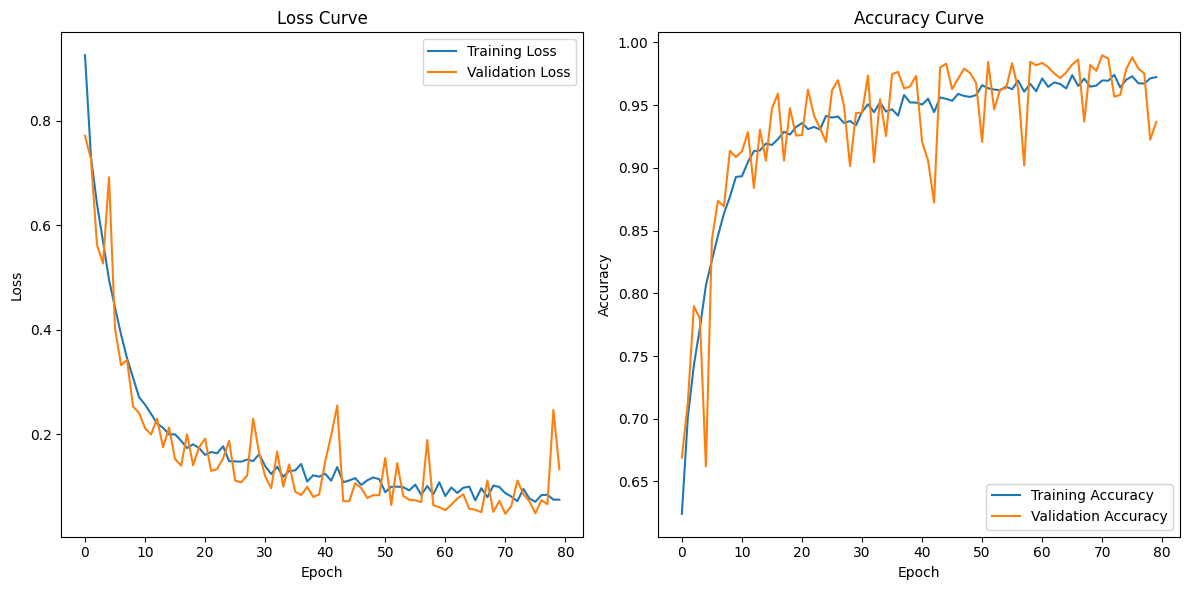

In [23]:
import matplotlib.pyplot as plt

# Plot Loss Curve
plt.figure(figsize=(12, 6))

# Plot loss pelatihan dan validasi
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Menampilkan plot
plt.tight_layout()
plt.show()


In [24]:
# Menghitung akurasi pada data test
test_loss, test_accuracy = model.evaluate(X_val, y_val)

# Menampilkan akurasi dalam persen
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9878 - loss: 0.0483
Test Accuracy: 98.98%


#Save Model

In [25]:
model.save('diabetes_model.keras')

#Tes Model

In [26]:
import numpy as np
from tensorflow.keras.models import load_model

# Memuat model yang telah disimpan
model = load_model('diabetes_model.keras')

# age  hypertension  heart_disease    bmi  HbA1c_level  blood_glucose_level, gender_encoded  smoking_history_encoded
# Contoh data input yang ingin diuji
input_data = np.array([[200, 0, 0, 27.3, 5.0, 200, 0, 4]])  # Misalnya data untuk 1 pasien

# Lakukan prediksi
predictions = model.predict(input_data)

# Ambil kelas dengan probabilitas tertinggi (untuk softmax output)
predicted_class = np.argmax(predictions, axis=-1)

print(predicted_class[0])

# Pemetaan kelas ke label
class_labels = ['Normal', 'Pra-diabetes', 'Diabetes Terkendali', 'Diabetes Tidak Terkendali']

# Tampilkan hasil prediksi
print(f"Prediksi Kelas: {class_labels[predicted_class[0]]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
3
Prediksi Kelas: Diabetes Tidak Terkendali
